# Estimating space an time needed for PDD inference

In [1]:
! nvidia-smi

Tue Feb  8 16:06:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
|  0%   42C    P2    56W / 250W |   9607MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:5E:00.0 Off |                  N/A |
|  0%   

In [2]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff

os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f7266e434c0>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [3]:
W,H = (150,150)
o_m = H//4 +1
o_n = W//4 +1
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
grid_size = 32#25#30
disp_hw = 5
displace_range = 11
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features

In [4]:
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [5]:
path_to_state_dict = "models/Experiment_3/14_10_21-16-40/student_0.pth"
model_24 = OBELISK2d(24)
model_24.load_state_dict(torch.load(path_to_state_dict))

path_to_state_dict = "models/Experiment_2/obel16_ensemble_13_10_21-21-30.pth"
model_16 = OBELISK2d(16)
model_16.load_state_dict(torch.load(path_to_state_dict))

<All keys matched successfully>

# Space usage of different models
comparing the inferenc time of models with 16 and 24 feature channels and the baseline algorithm

In [6]:
from torchsummary import summary

In [6]:
summary(model_16.cuda(), torch.zeros(1,1,150,150), verbose=False, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 4, 38, 38]           100
├─BatchNorm2d: 1-2                       [-1, 4, 38, 38]           8
├─Conv2d: 1-3                            [-1, 64, 37, 37]          8,192
├─BatchNorm2d: 1-4                       [-1, 64, 37, 37]          128
├─Conv2d: 1-5                            [-1, 64, 37, 37]          36,864
├─BatchNorm2d: 1-6                       [-1, 64, 37, 37]          128
├─Conv2d: 1-7                            [-1, 16, 37, 37]          1,040
Total params: 46,460
Trainable params: 46,460
Non-trainable params: 0
Total mult-adds (M): 63.23
Input size (MB): 0.09
Forward/backward pass size (MB): 2.93
Params size (MB): 0.18
Estimated Total Size (MB): 3.19

In [7]:
summary(model_24.cuda(), torch.zeros(1,1,150,150), verbose=False, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 4, 38, 38]           100
├─BatchNorm2d: 1-2                       [-1, 4, 38, 38]           8
├─Conv2d: 1-3                            [-1, 96, 37, 37]          18,432
├─BatchNorm2d: 1-4                       [-1, 96, 37, 37]          192
├─Conv2d: 1-5                            [-1, 96, 37, 37]          82,944
├─BatchNorm2d: 1-6                       [-1, 96, 37, 37]          192
├─Conv2d: 1-7                            [-1, 24, 37, 37]          2,328
Total params: 104,196
Trainable params: 104,196
Non-trainable params: 0
Total mult-adds (M): 142.08
Input size (MB): 0.09
Forward/backward pass size (MB): 4.35
Params size (MB): 0.40
Estimated Total Size (MB): 4.83

# Time 

In [8]:
import torch.utils.benchmark as benchmark
import time

Time of a 24 feature channel model

In [11]:
t0 = benchmark.Timer(
    stmt='feat1 = model(img1)\nfeat2 = model(img2)\nssd_distance = correlation_layer(displace_range, feat2, feat1)\nsoft_cost,disp_xy = meanfield(ssd_distance, img1, displace_range, H//4, W//4)\nflow=interpolate(disp_xy,size=(150,150))',
    globals={'model': model_24.cpu(), 
            'img1': torch.rand(1,1,150,150).cpu(),
             'img2': torch.rand(1,1,150,150).cpu(),
             'correlation_layer': correlation_layer,
            'displace_range': displace_range,
            'meanfield': meanfield,
            'H': 150,
            'W': 150,
            'interpolate': F.interpolate})
t0.timeit(100)

stmt:
  feat1 = model(img1)
  feat2 = model(img2)
  ssd_distance = correlation_layer(displace_range, feat2, feat1)
  soft_cost,disp_xy = meanfield(ssd_distance, img1, displace_range, H//4, W//4)
  flow=interpolate(disp_xy,size=(150,150))

  86.20 ms
  1 measurement, 100 runs , 1 thread

In [26]:
# doing it manually to have a time plot and a mean
times = []
for i in range(100):
    
    # create pseudo imgs
    img1 = torch.rand(1,1,150,150)
    img2 = torch.rand(1,1,150,150)
    
    # measure time
    start = time.time()
    
    # forward pass
    feat1 = model_24(img2)
    feat2 = model_24(img1)
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, img1, displace_range, H//4, W//4)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150))
    
    # end measurement
    end = time.time()
    times.append(end-start)

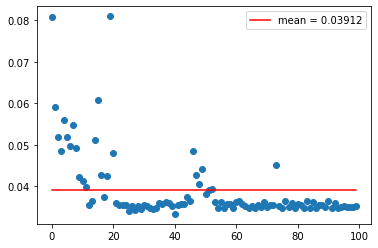

In [27]:
plt.scatter(x=np.arange(100), y=times)
plt.plot(np.tile(np.mean(times), 100), color='r', label=f'mean = {round(np.mean(times), 5)}')
plt.legend()
plt.savefig('plots/runtime_model24_cpu.png')

Time of a 16 feature channel model

In [28]:
t0 = benchmark.Timer(
    stmt='feat1 = model(img1)\nfeat2 = model(img1)\nssd_distance = correlation_layer(displace_range, feat2, feat1)\nsoft_cost,disp_xy = meanfield(ssd_distance, img1, displace_range, H//4, W//4)\nflow=interpolate(disp_xy,size=(150,150))',
    globals={'model': model_16.cpu(), 
            'img1': torch.rand(1,1,150,150).cpu(),
             'img2': torch.rand(1,1,150,150).cpu(),
             'correlation_layer': correlation_layer,
            'displace_range': displace_range,
            'meanfield': meanfield,
            'H': 150,
            'W': 150,
            'interpolate': F.interpolate})
t0.timeit(100)

stmt:
  feat1 = model(img1)
  feat2 = model(img1)
  ssd_distance = correlation_layer(displace_range, feat2, feat1)
  soft_cost,disp_xy = meanfield(ssd_distance, img1, displace_range, H//4, W//4)
  flow=interpolate(disp_xy,size=(150,150))

  81.16 ms
  1 measurement, 100 runs , 1 thread

In [29]:
# doing it manually to have a time plot and a mean
times = []
for i in range(100):
    
    # create pseudo imgs
    img1 = torch.rand(1,1,150,150)
    img2 = torch.rand(1,1,150,150)
    
    # measure time
    start = time.time()
    
    # forward pass
    feat1 = model_16(img2)
    feat2 = model_16(img1)
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, img1, displace_range, H//4, W//4)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150))
    
    # end measurement
    end = time.time()
    times.append(end-start)

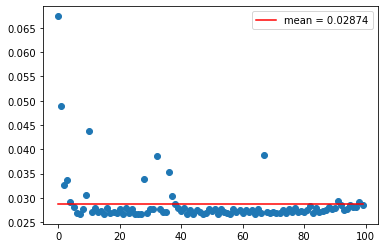

In [30]:
plt.scatter(x=np.arange(100), y=times)
plt.plot(np.tile(np.mean(times), 100), color='r', label=f'mean = {round(np.mean(times), 5)}')
plt.legend()
plt.savefig('plots/runtime_model16_cpu.png')

Time of the baseline

In [31]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()
print("Inner iterations: ", baseline.getInnerIterations())
print("Outer iterations: ", baseline.getOuterIterations())

Inner iterations:  30
Outer iterations:  10


In [12]:
t0 = benchmark.Timer(
    stmt='calc(in1,in2,None)',
    num_threads=10,
    globals={'calc': baseline.calc, 
            'in1': np.random.uniform(size=(150,150,1)).astype(np.float32),
             'in2': np.random.uniform(size=(150,150,1)).astype(np.float32)})
t0.timeit(100)

calc(in1,in2,None)
  358.93 ms
  1 measurement, 100 runs , 10 threads

In [13]:
t0 = benchmark.Timer(
    stmt='calc(in1,in2,None)',
    globals={'calc': baseline.calc, 
            'in1': np.random.uniform(size=(150,150,1)).astype(np.float32),
             'in2': np.random.uniform(size=(150,150,1)).astype(np.float32)})
t0.timeit(100)

calc(in1,in2,None)
  368.48 ms
  1 measurement, 100 runs , 1 thread

In [17]:
t0 = benchmark.Timer(
    stmt='calc(in1,in2,None)',
    num_threads=50,
    globals={'calc': baseline.calc, 
            'in1': np.random.uniform(size=(150,150,1)).astype(np.float32),
             'in2': np.random.uniform(size=(150,150,1)).astype(np.float32)})
t0.timeit(100)

calc(in1,in2,None)
  362.51 ms
  1 measurement, 100 runs , 50 threads

In [32]:
# doing it manually to have a time plot and a mean
times = []
for i in range(100):
    
    # create pseudo imgs
    img1 = np.random.uniform(size=(150,150,1)).astype(np.float32)
    img2 = np.random.uniform(size=(150,150,1)).astype(np.float32)
    
    # measure time
    start = time.time()
    flow = baseline.calc(img1, img2, None)
    
    # end measurement
    end = time.time()
    times.append(end-start)

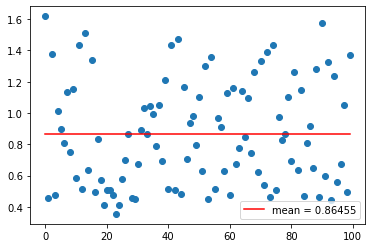

In [33]:
plt.scatter(x=np.arange(100), y=times)
plt.plot(np.tile(np.mean(times), 100), color='r', label=f'mean = {round(np.mean(times), 5)}')
plt.legend()
plt.savefig('plots/runtime_baseline_cpu.png')

# Verdict
Running it on the server on Tue 26.10.2021 around 22:20 - 22:25 with no other thread using the CPUs and GPUs.

I am getting 358 ms with 10m, 365 ms with 1 thread and 362 ms with 50 threads for DualTVL1 and 91.05 or 74ms for the two PDD-Nets 24 and 16 respectively.
With GPU acceleration, these numbers drop to 2.8 and 2.1 ms respectively. 
Taking the mean of about 80ms, and 360ms for the baseline, the PDD-Net is about 4.5 times faster in computation. 

In [10]:
import time

In [11]:
model = OBELISK2d(16)
model.cuda()

seq = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
seq.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4), dilation=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): PReLU(num_parameters=1)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): PReLU(num_parameters=1)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): PReLU(num_parameters=1)
  (9): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (10): Sigmoid()
)

In [12]:
obel_time = []
seq_time = []
for i in range(100):
    in1 = torch.rand(1,1,150,150)
    in2 = torch.rand(1,1,150,150)
    
    feat1 = model(in1.cuda())
    start = time.time()
    #feat1 = model(in1.cuda())
    feat2 = model(in2.cuda())
    ssd_distance = correlation_layer(displace_range, feat1, feat2)
    soft_cost,disp_xy = meanfield(ssd_distance, in1, displace_range, H//4 +1, W//4 +1)
    end = time.time()
    
    obel_time.append((end-start)*1000)
    
    
    in1 = torch.rand(1,1,150,150)
    in2 = torch.rand(1,1,150,150)
    
    feat1 = seq(in1.cuda())
    start = time.time()
    #feat1 = seq(in1.cuda())
    
    feat2 = seq(in2.cuda())
    ssd_distance = correlation_layer(displace_range, feat1, feat2)
    soft_cost,disp_xy = meanfield(ssd_distance, in1, displace_range, H//4 +1, W//4 +1)
    end = time.time()
    
    seq_time.append((end-start)*1000)

findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.


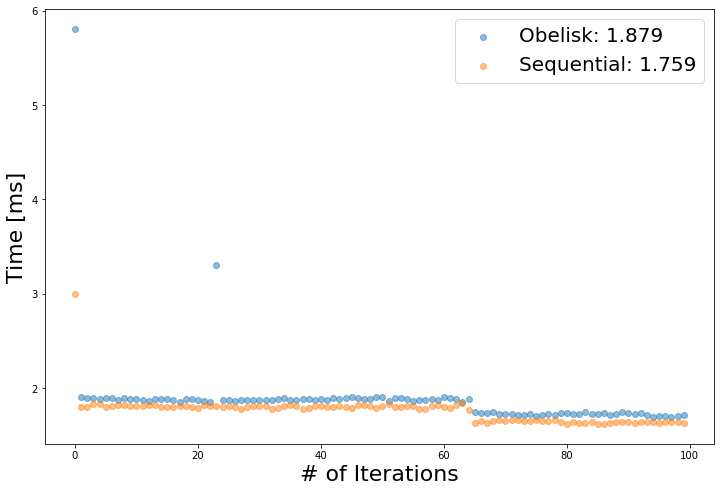

In [13]:
fonts = {'fontsize': 22,'family': 'Latin Modern Roman'}
plt.figure(figsize=(12,8))

plt.scatter(np.arange(100), obel_time, label=f'Obelisk: {round(np.mean(obel_time), 3)}', alpha=0.5)
plt.scatter(np.arange(100), seq_time, label=f'Sequential: {round(np.mean(seq_time), 3)}', alpha=0.5)
plt.xlabel('# of Iterations', fontdict=fonts)
plt.ylabel('Time [ms]', fontdict=fonts)
plt.legend(fontsize=20)
plt.show()